https://www.kaggle.com/datasets/ealaxi/banksim1/data



# Dataset overview

We detect the fraudulent transactions from the Banksim dataset. This synthetically generated dataset consists of payments from various customers made in different time periods and with different amounts. The features are as follows:

- Step: This feature represents the day from the start of simulation. It has 180 steps so simulation ran for virtually 6 months.
- Customer: This feature represents the customer id
- zipCodeOrigin: The zip code of origin/source.
- Merchant: The merchant's id
- zipMerchant: The merchant's zip code
- Age: Categorized age
    - 0: <= 18,
    - 1: 19-25,
    - 2: 26-35,
    - 3: 36-45,
    - 4: 46-55,
    - 5: 56-65,
    - 6: > 65
    - U: Unknown
- Gender: Gender for customer
    - E : Enterprise,
    - F: Female,
    - M: Male,
    - U: Unknown
- Category: Category of the purchase. I won't write all categories here, we'll see them later in the analysis.
- Amount: Amount of the purchase
- Fraud: Target variable which shows if the transaction fraudulent(1) or benign(0)



# Import Libraries and Read Data

In [4]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

# Machine Learning and Data Preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_fscore_support, f1_score
from scipy.stats import randint
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer

# Neural Networks and Tuning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner import HyperModel, Objective

# Configuration and Style
plt.style.use('ggplot')
warnings.simplefilter(action='ignore', category=FutureWarning)
start_time = time.time()


In [5]:
# Read in data files

file_path = '../data/fraud_dataset.csv'

df = pd.read_csv(file_path)
   
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


# EDA

In [7]:
# Check the size of the dataset
df_size = df.shape

# Summarize data types
df_data_types = df.dtypes

# Check for missing values
df_missing_values = df.isnull().sum()

# Basic statistical summary for numerical columns
df_statistical_summary = df.describe()

df_size, df_data_types, df_missing_values, df_statistical_summary


((594643, 10),
 step             int64
 customer        object
 age             object
 gender          object
 zipcodeOri      object
 merchant        object
 zipMerchant     object
 category        object
 amount         float64
 fraud            int64
 dtype: object,
 step           0
 customer       0
 age            0
 gender         0
 zipcodeOri     0
 merchant       0
 zipMerchant    0
 category       0
 amount         0
 fraud          0
 dtype: int64,
                 step         amount          fraud
 count  594643.000000  594643.000000  594643.000000
 mean       94.986827      37.890135       0.012108
 std        51.053632     111.402831       0.109369
 min         0.000000       0.000000       0.000000
 25%        52.000000      13.740000       0.000000
 50%        97.000000      26.900000       0.000000
 75%       139.000000      42.540000       0.000000
 max       179.000000    8329.960000       1.000000)

**Initial Dataset Analysis**:
- The dataset contains 594,643 transactions with 10 columns.
- There are no missing values in the dataset, which is excellent for data analysis.

**Data Types and Summary:**
- Numerical columns: step, amount, and fraud.
- Categorical columns: customer, age, gender, zipcodeOri, merchant, zipMerchant, category. These are all stored as object types and may need formatting for better analysis.
    
**Statistical Summary for Numerical Columns:**
- Step: Covers a range from 0 to 179, possibly days or time steps.
- Amount: The mean transaction amount is approximately 37.89, but there's a large range, suggesting variability in transaction sizes.
- Fraud: Only about 1.21% of transactions are fraudulent based on the mean of the fraud column.

**Initial Data Cleaning:**
- Drop Redundant Columns: zipcodeOri and zipMerchant have only one unique value ('28007') and can be removed.
- Format Cleaning: Remove quotes from string data in columns like customer, age, gender, merchant, and category.

In [10]:
# Drop redundant columns with only one unique value
df.drop(['zipcodeOri', 'zipMerchant'], axis=1, inplace=True)

# Clean up the data by removing quotes from string data
df['customer'] = df['customer'].str.strip("'")
df['age'] = df['age'].str.strip("'")
df['gender'] = df['gender'].str.strip("'")
df['merchant'] = df['merchant'].str.strip("'")
df['category'] = df['category'].str.strip("'")

# Display the cleaned dataframe to verify changes
df.head()


,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0


The two zip code columns are constant for each value and thus provide no additional information.  These will be dropped.

## Target Variable

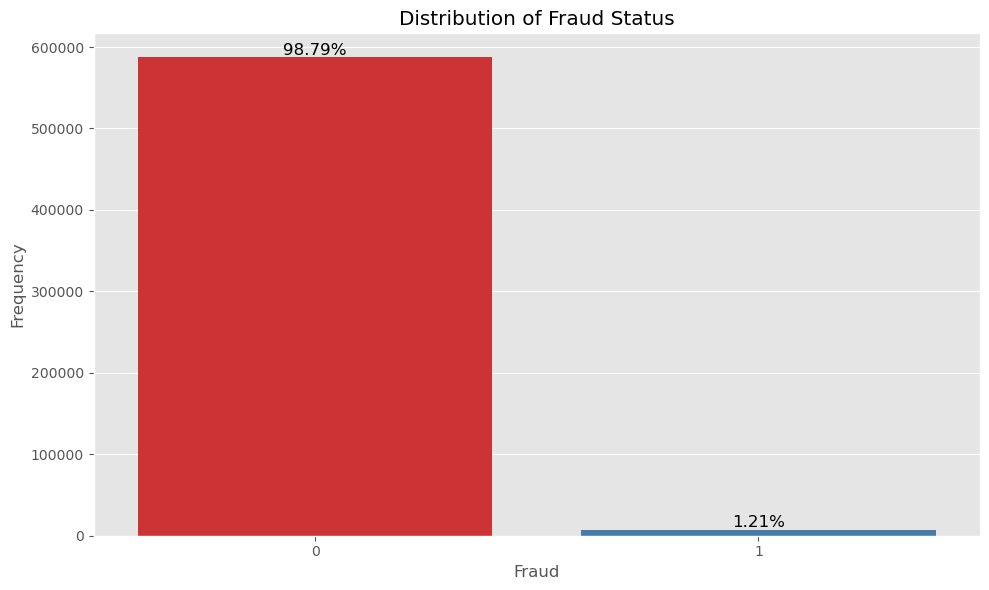

In [13]:
# Assume df is already loaded with your data
# df = pd.read_csv('path_to_your_data.csv')  # Uncomment and adjust if the dataframe needs to be loaded

# Displaying the plot for fraud status
fig, ax = plt.subplots(figsize=(10, 6))

# Fraud distribution
count_plot = sns.countplot(x='fraud', data=df, ax=ax, palette='Set1')
ax.set_title('Distribution of Fraud Status')
ax.set_xlabel('Fraud')
ax.set_ylabel('Frequency')

# Calculate the total number of entries to get percentages
total = len(df['fraud'])

# Adding percentages above each bar
for p in count_plot.patches:
    height = p.get_height()
    count_plot.annotate(f'{100 * height / total:.2f}%', (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                        textcoords='offset points')

plt.tight_layout()
plt.show()



Target Variable:
- Fraud Status: This plot highlights the imbalance between fraudulent and non-fraudulent transactions, with non-fraudulent transactions significantly outnumbering fraudulent ones. Such an imbalance is typical in fraud detection scenarios and poses challenges in modeling and analysis.

## Univariate Analysis

### Numerical Columns

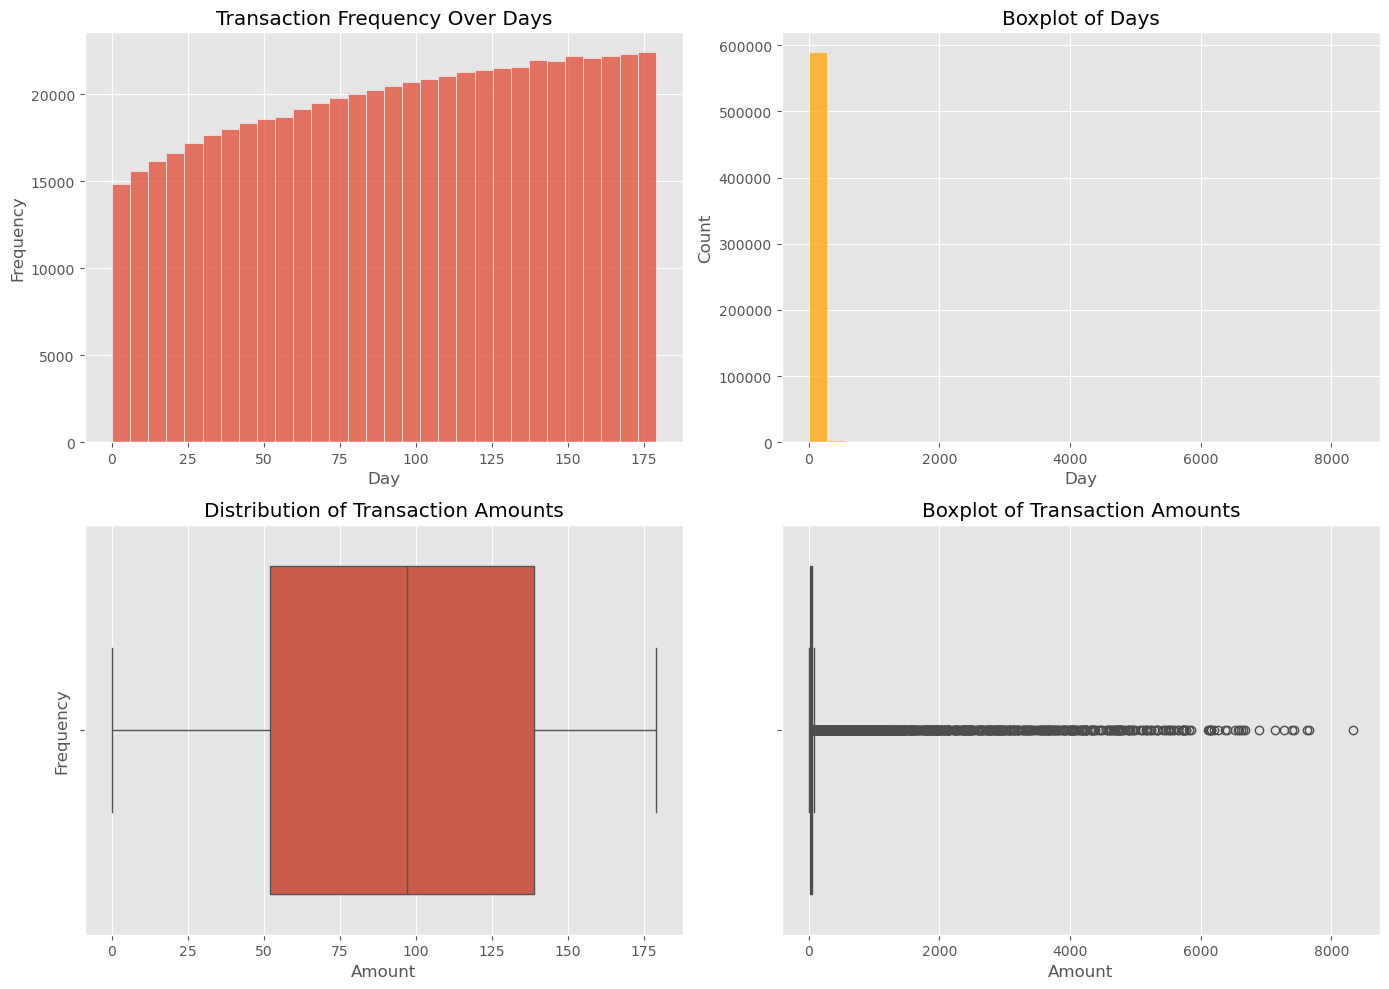

(count    594643.000000
 mean         94.986827
 std          51.053632
 min           0.000000
 25%          52.000000
 50%          97.000000
 75%         139.000000
 max         179.000000
 Name: step, dtype: float64,
 count    594643.000000
 mean         37.890135
 std         111.402831
 min           0.000000
 25%          13.740000
 50%          26.900000
 75%          42.540000
 max        8329.960000
 Name: amount, dtype: float64)

In [17]:
# Univariate Analysis for 'step' and 'amount'
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Histogram for 'step'
sns.histplot(df['step'], bins=30, kde=False, ax=ax[0, 0])
ax[0, 0].set_title('Transaction Frequency Over Days')
ax[0, 0].set_xlabel('Day')
ax[0, 0].set_ylabel('Frequency')

# Histogram for 'amount'
sns.histplot(df['amount'], bins=30, kde=False, ax=ax[0, 1], color='orange')
ax[1, 0].set_title('Distribution of Transaction Amounts')
ax[1, 0].set_xlabel('Amount')
ax[1, 0].set_ylabel('Frequency')

# Boxplot for 'step'
sns.boxplot(x=df['step'], ax=ax[1, 0])
ax[0, 1].set_title('Boxplot of Days')
ax[0, 1].set_xlabel('Day')

# Boxplot for 'amount'
sns.boxplot(x=df['amount'], ax=ax[1, 1], color='orange')
ax[1, 1].set_title('Boxplot of Transaction Amounts')
ax[1, 1].set_xlabel('Amount')

plt.tight_layout()
plt.show()

# Summary statistics for 'step' and 'amount'
step_summary = df['step'].describe()
amount_summary = df['amount'].describe()

step_summary, amount_summary


**Univariate Analysis Results - Numerical Columns**
- Step (Time):
    - Histogram: Transactions are relatively evenly distributed over the 180 days, with a slight increase in frequency towards the end. This suggests a stable usage pattern with some growth or seasonal effects.
    - Boxplot: Indicates that the df is uniformly distributed across the time frame, with no outliers.
    - Summary Statistics: 
        - Mean day is approximately 95 (middle of the 180-day period).  
        - Standard deviation of 51 days indicates a uniform spread throughout the period.
        
- Amount:
    - Histogram: The distribution of transaction amounts is heavily right-skewed, showing that most transactions are of lower value, with a few high-value outliers.
    - Boxplot: Confirms the presence of outliers with very high transaction amounts.
    - Summary Statistics: 
        - Mean transaction amount is approximately $37.89.
        - A high standard deviation ($111.40) relative to the mean suggests significant variability, primarily driven by outliers.
        - The median ($26.90) being lower than the mean also indicates a right-skewed distribution.

### Categorical Columnns

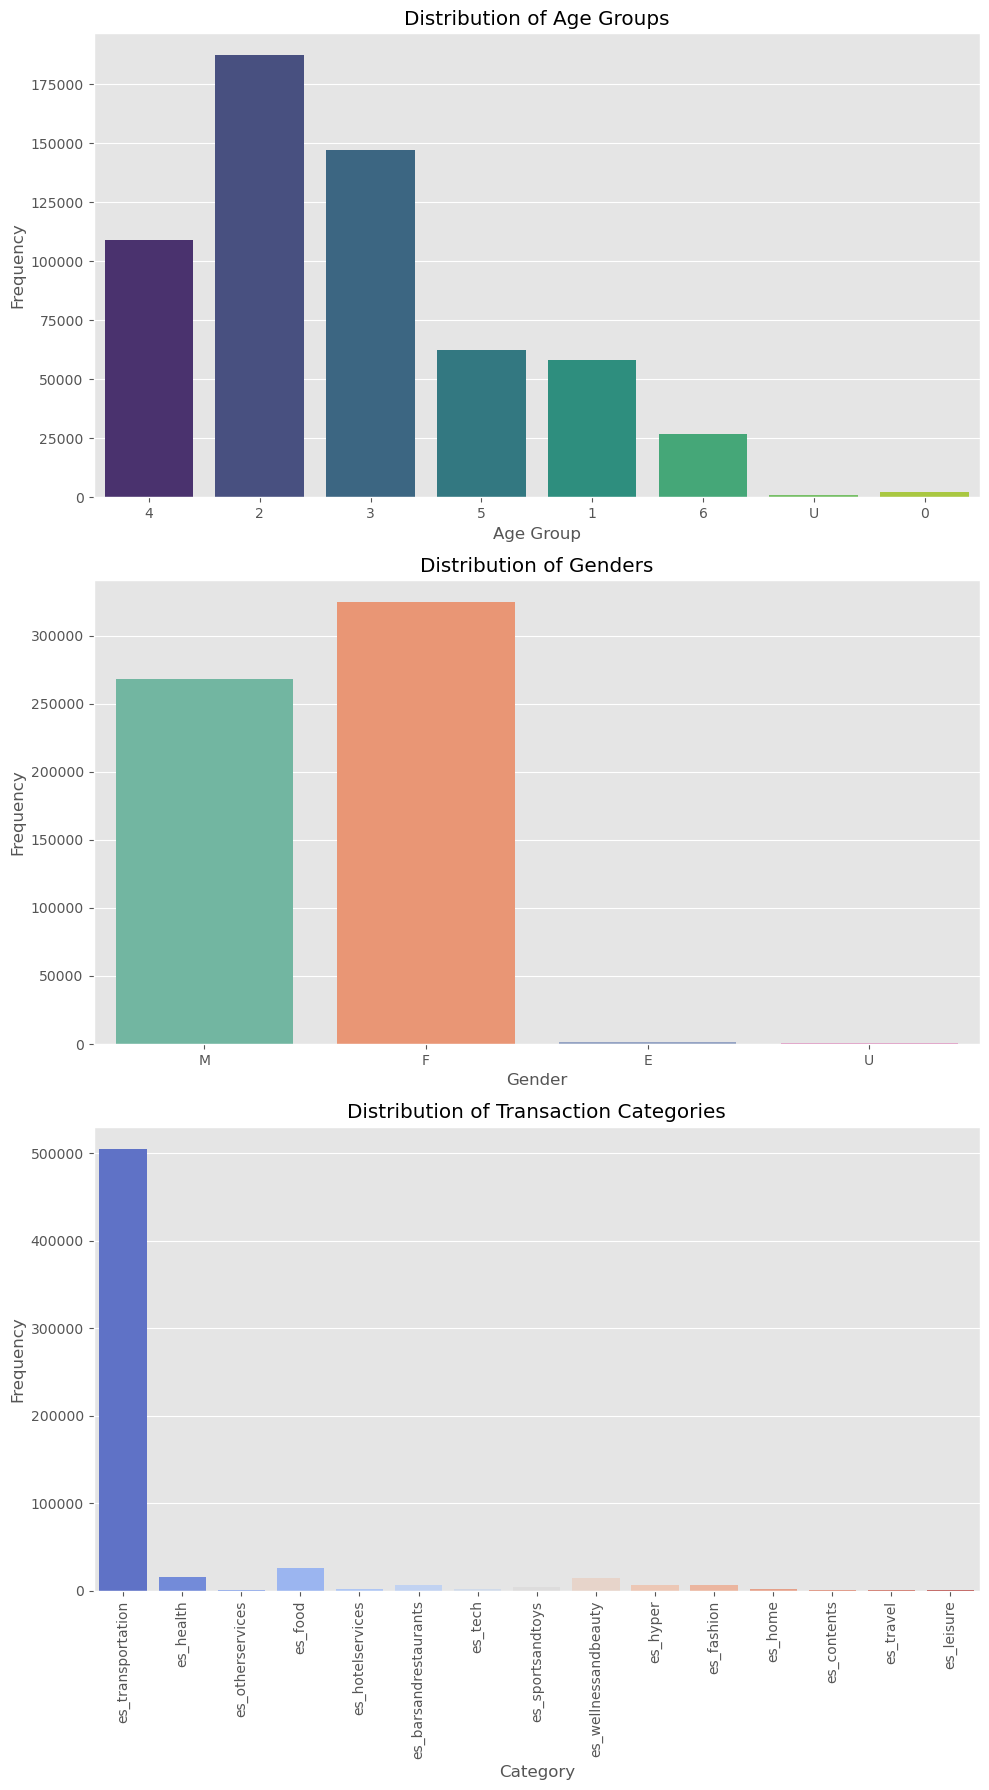

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume df is already loaded with your data
# df = pd.read_csv('path_to_your_data.csv')  # Uncomment and adjust if the dataframe needs to be loaded

# Univariate Analysis for categorical variables
fig, ax = plt.subplots(3, 1, figsize=(10, 18))  # Adjusted subplot configuration to 3x1

# Age distribution
sns.countplot(x='age', data=df, ax=ax[0], palette='viridis')
ax[0].set_title('Distribution of Age Groups')
ax[0].set_xlabel('Age Group')
ax[0].set_ylabel('Frequency')

# Gender distribution
sns.countplot(x='gender', data=df, ax=ax[1], palette='Set2')
ax[1].set_title('Distribution of Genders')
ax[1].set_xlabel('Gender')
ax[1].set_ylabel('Frequency')

# Category distribution
sns.countplot(x='category', data=df, ax=ax[2], palette='coolwarm')
ax[2].set_title('Distribution of Transaction Categories')
ax[2].set_xlabel('Category')
ax[2].set_ylabel('Frequency')
ax[2].tick_params(axis='x', rotation=90)  # Rotating category labels for better readability

plt.tight_layout()
plt.show()



**Univariate Analysis Results - Categorical Columns**

- Age Group: Distribution shows that certain age groups are more prevalent in the dataset. This can help identify which groups are more active in transactions.
- Gender: The gender distribution helps understand the demographic split of the dataset users. There's a visible distribution between different genders which may influence transaction patterns.
- Transaction Categories: There's significant variation in the frequency of different transaction categories. Some categories are much more common, which may impact the focus of fraud detection strategies. Categories with fewer transactions but higher fraud rates could be particularly important.


Let's analyze the top merchants and customers in terms of transaction frequency and fraud incidence to identify any patterns or outliers. We'll focus on the top 10 merchants and customers based on the total number of transactions, and then examine their association with fraudulent transactions.


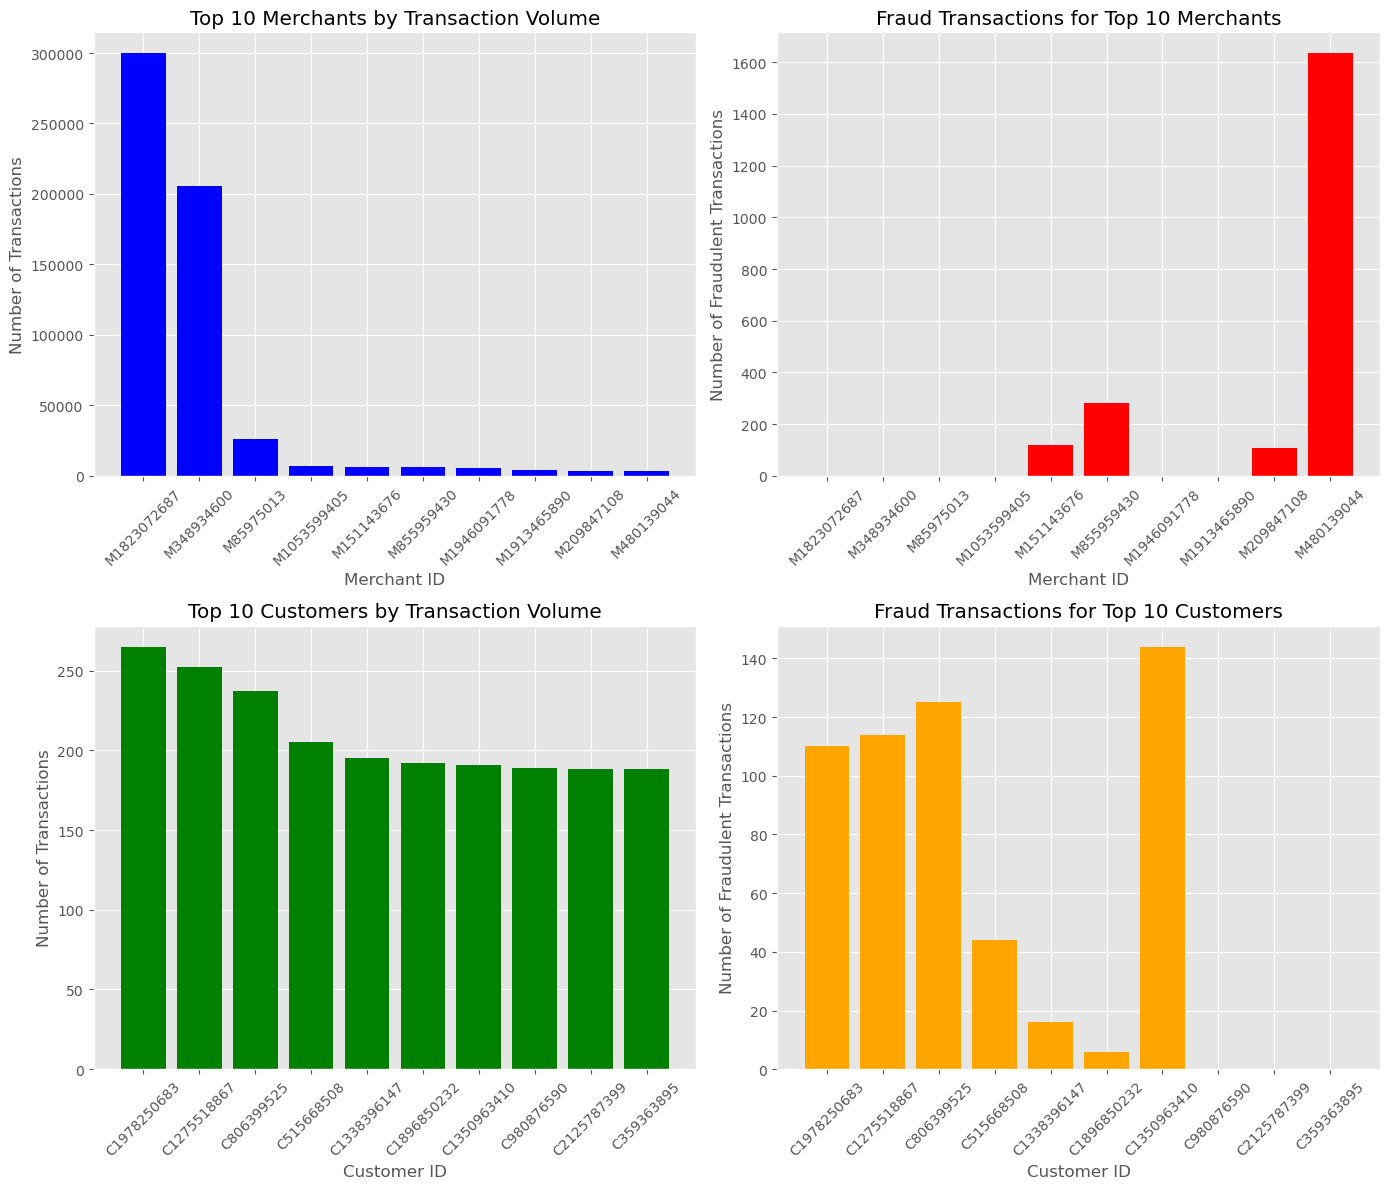

In [23]:
# Calculating the top 10 merchants and customers by transaction volume
top_merchants = df['merchant'].value_counts().head(10)
top_customers = df['customer'].value_counts().head(10)

# Calculating fraud incidences for top 10 merchants and customers
top_merchants_fraud = df[df['fraud'] == 1]['merchant'].value_counts().reindex(top_merchants.index, fill_value=0)
top_customers_fraud = df[df['fraud'] == 1]['customer'].value_counts().reindex(top_customers.index, fill_value=0)

# Plotting results
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# Top 10 merchants by transaction volume
ax[0, 0].bar(top_merchants.index, top_merchants, color='blue')
ax[0, 0].set_title('Top 10 Merchants by Transaction Volume')
ax[0, 0].set_xlabel('Merchant ID')
ax[0, 0].set_ylabel('Number of Transactions')
ax[0, 0].tick_params(axis='x', rotation=45)

# Fraud transactions for top 10 merchants
ax[0, 1].bar(top_merchants_fraud.index, top_merchants_fraud, color='red')
ax[0, 1].set_title('Fraud Transactions for Top 10 Merchants')
ax[0, 1].set_xlabel('Merchant ID')
ax[0, 1].set_ylabel('Number of Fraudulent Transactions')
ax[0, 1].tick_params(axis='x', rotation=45)

# Top 10 customers by transaction volume
ax[1, 0].bar(top_customers.index, top_customers, color='green')
ax[1, 0].set_title('Top 10 Customers by Transaction Volume')
ax[1, 0].set_xlabel('Customer ID')
ax[1, 0].set_ylabel('Number of Transactions')
ax[1, 0].tick_params(axis='x', rotation=45)

# Fraud transactions for top 10 customers
ax[1, 1].bar(top_customers_fraud.index, top_customers_fraud, color='orange')
ax[1, 1].set_title('Fraud Transactions for Top 10 Customers')
ax[1, 1].set_xlabel('Customer ID')
ax[1, 1].set_ylabel('Number of Fraudulent Transactions')
ax[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Top 10 Merchants:
- Transaction Volume: The bar graph shows that some merchants have significantly higher transaction volumes than others.
- Fraud Incidences: For these top merchants, the number of fraudulent transactions varies. Some merchants have a relatively higher incidence of fraud, which could suggest areas where increased monitoring might be necessary.

Top 10 Customers:
- Transaction Volume: Similar to merchants, some customers engage in far more transactions than others, highlighting their potential influence or importance in the dataset.
- Fraud Incidences: The distribution of fraudulent transactions among these customers shows that fraud is not uniformly spread, indicating that certain customers might be more susceptible to fraud or involved in fraudulent activities.

Explore the zipcodeOri and zipMerchant to confirm if any variability exists.

## Bivariate Analysis

### Numerical vs Numerical

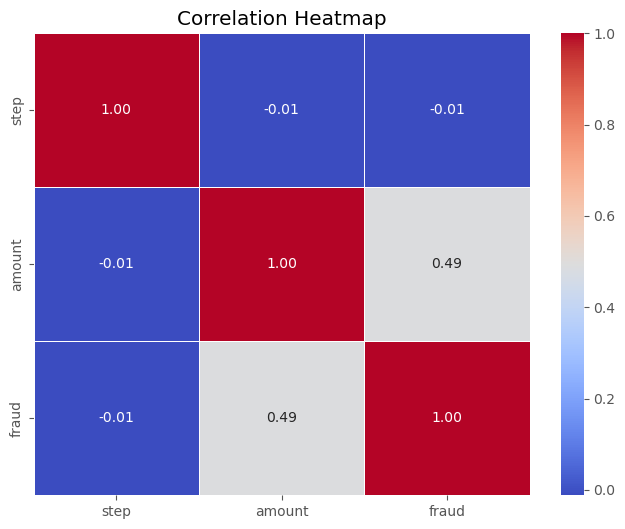

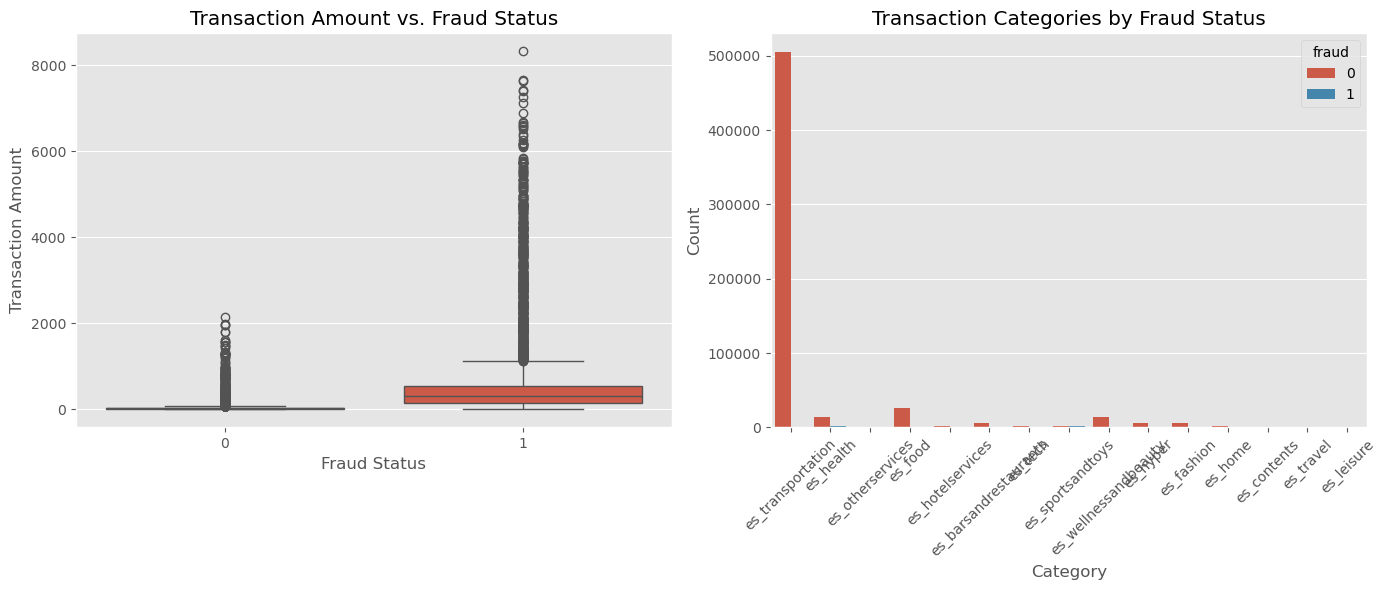

In [28]:
# Setting up the correlation heatmap for numerical variables
fig, ax = plt.subplots(figsize=(8, 6))

# Compute the correlation matrix
correlation_matrix = df[['step', 'amount', 'fraud']].corr()

# Generate a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax)
ax.set_title('Correlation Heatmap')
plt.show()

# Investigating patterns of fraud in relation to different features
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot for 'amount' by 'fraud' status
sns.boxplot(x='fraud', y='amount', data=df, ax=axes[0])
axes[0].set_title('Transaction Amount vs. Fraud Status')
axes[0].set_xlabel('Fraud Status')
axes[0].set_ylabel('Transaction Amount')

# Count plot for 'category' with hue 'fraud'
sns.countplot(x='category', hue='fraud', data=df, ax=axes[1])
axes[1].set_title('Transaction Categories by Fraud Status')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)  # Rotate x labels for better readability

plt.tight_layout()
plt.show()


The correlation heatmap analyzed the relationships between step, amount, and fraud in the transaction data. Key findings include:
- Step and Amount: Show a very low correlation, indicating no significant linear relationship over time.
- Step and Fraud: Also exhibit minimal correlation, suggesting fraud occurrences are not tied to specific time steps.
- Amount and Fraud: Display a moderate positive correlation, indicating that higher transaction amounts are more likely to be associated with fraud.

This analysis highlights that while time factors (step) do not significantly influence transaction amounts or fraud occurrences, the transaction amount is a relevant predictor of fraud, underscoring the importance of monitoring larger transactions more closely in fraud detection efforts.

For the 2 other plots:
- Transaction Amount vs. Fraud Status: The box plot illustrates that fraudulent transactions tend to have higher transaction amounts compared to non-fraudulent ones, which could be a significant indicator in identifying fraud.
- Transaction Categories by Fraud Status: This count plot shows how the frequency of transactions varies by category and fraud status. Some categories appear more susceptible to fraud than others, which is important for developing targeted fraud detection strategies.

### Categorical vs Numerical

I would normally use box plots to explore categorical vs numerical relationships, but given the context of needing to understand detailed behaviors within the data, particularly in assessing fraud, violin plots are generally more informative for this dataset. They provide a fuller picture of the transaction amounts across different categories and how those distributions differ between fraudulent and non-fraudulent transactions.


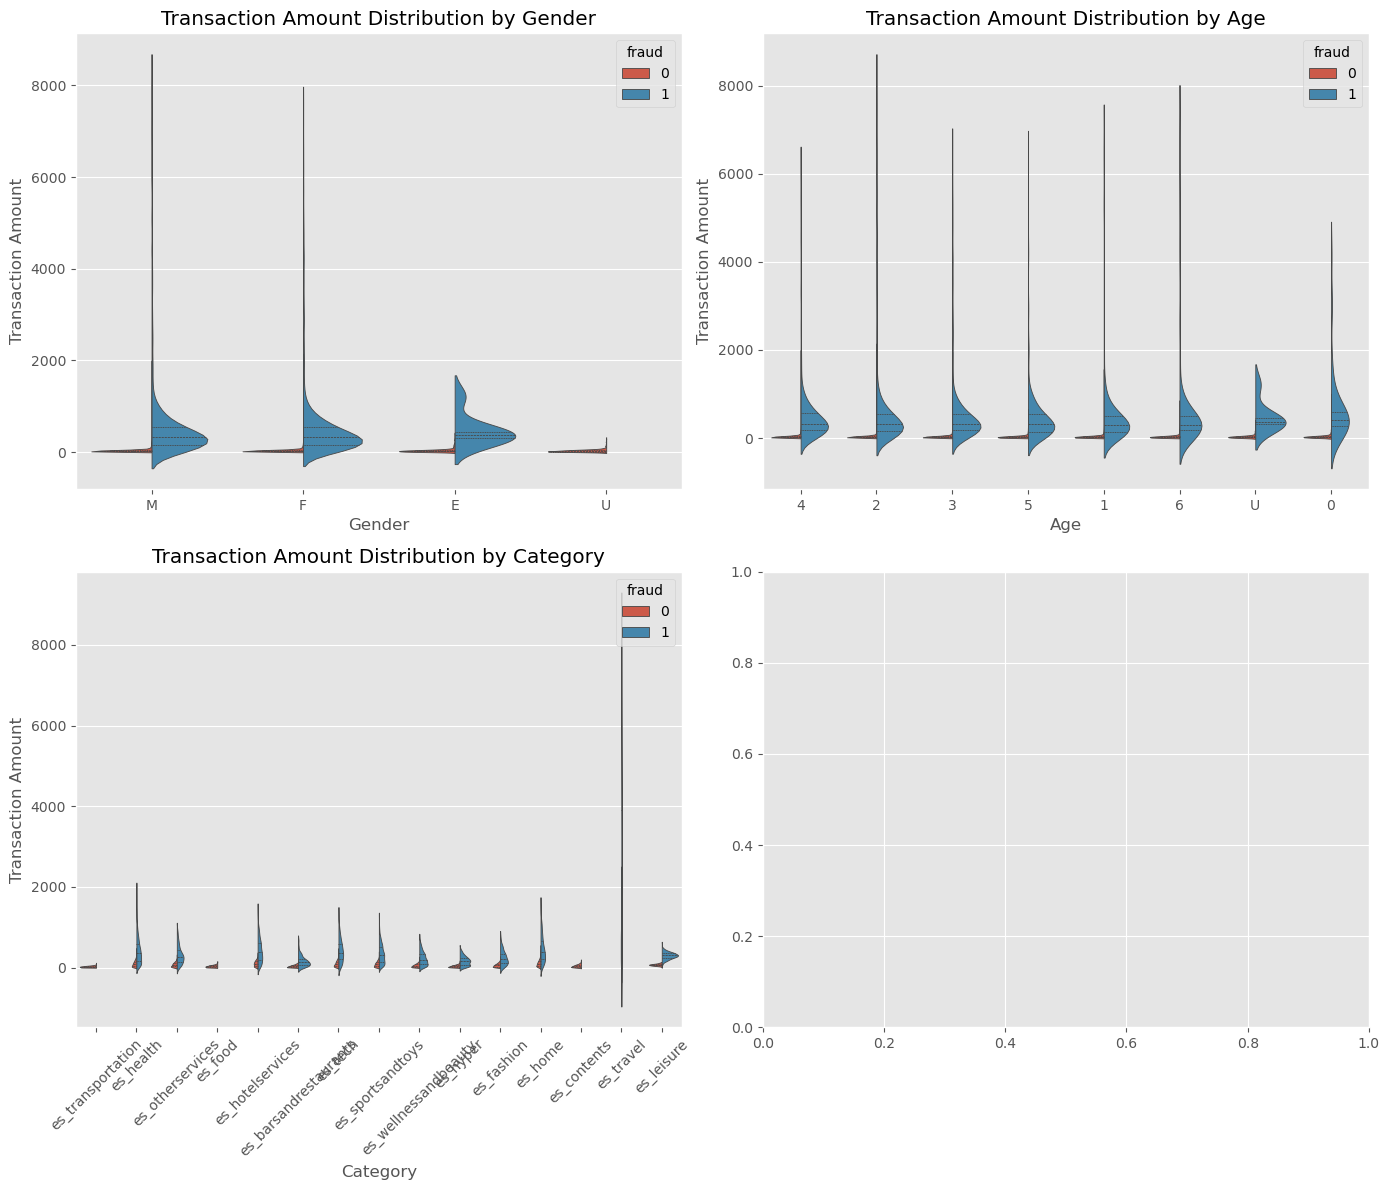

In [32]:
# Setting up a larger plotting area for multiple plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Violin plot for 'amount' across different 'gender' categories
sns.violinplot(x='gender', y='amount', hue='fraud', data=df, split=True, inner='quartile', ax=axes[0, 0])
axes[0, 0].set_title('Transaction Amount Distribution by Gender')
axes[0, 0].set_xlabel('Gender')
axes[0, 0].set_ylabel('Transaction Amount')

# Violin plot for 'amount' across different 'age' categories
sns.violinplot(x='age', y='amount', hue='fraud', data=df, split=True, inner='quartile', ax=axes[0, 1])
axes[0, 1].set_title('Transaction Amount Distribution by Age')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Transaction Amount')

# Violin plot for 'amount' across different 'category' categories
sns.violinplot(x='category', y='amount', hue='fraud', data=df, split=True, inner='quartile', ax=axes[1, 0])
axes[1, 0].set_title('Transaction Amount Distribution by Category')
axes[1, 0].set_xlabel('Category')
axes[1, 0].set_ylabel('Transaction Amount')
axes[1, 0].tick_params(axis='x', rotation=45)  # Rotate x labels for better readability

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Preparing to handle 'merchant' and 'customer' in subsequent plots due to their volume.


The violin plots for gender, age, and category are displayed above, providing detailed insights into the distribution of transaction amounts within these categories, split by fraud status:
- Gender: Shows how transaction amounts are distributed across genders. Both fraudulent and non-fraudulent transactions are represented, indicating typical transaction sizes and the spread for both.
- Age: Different age groups display varying patterns in transaction amounts, with the fraudulent transactions typically showing higher amounts across most age categories.
- Category: Each category has distinct characteristics in terms of transaction amount distributions, with fraud typically occurring at higher transaction amounts in many categories.

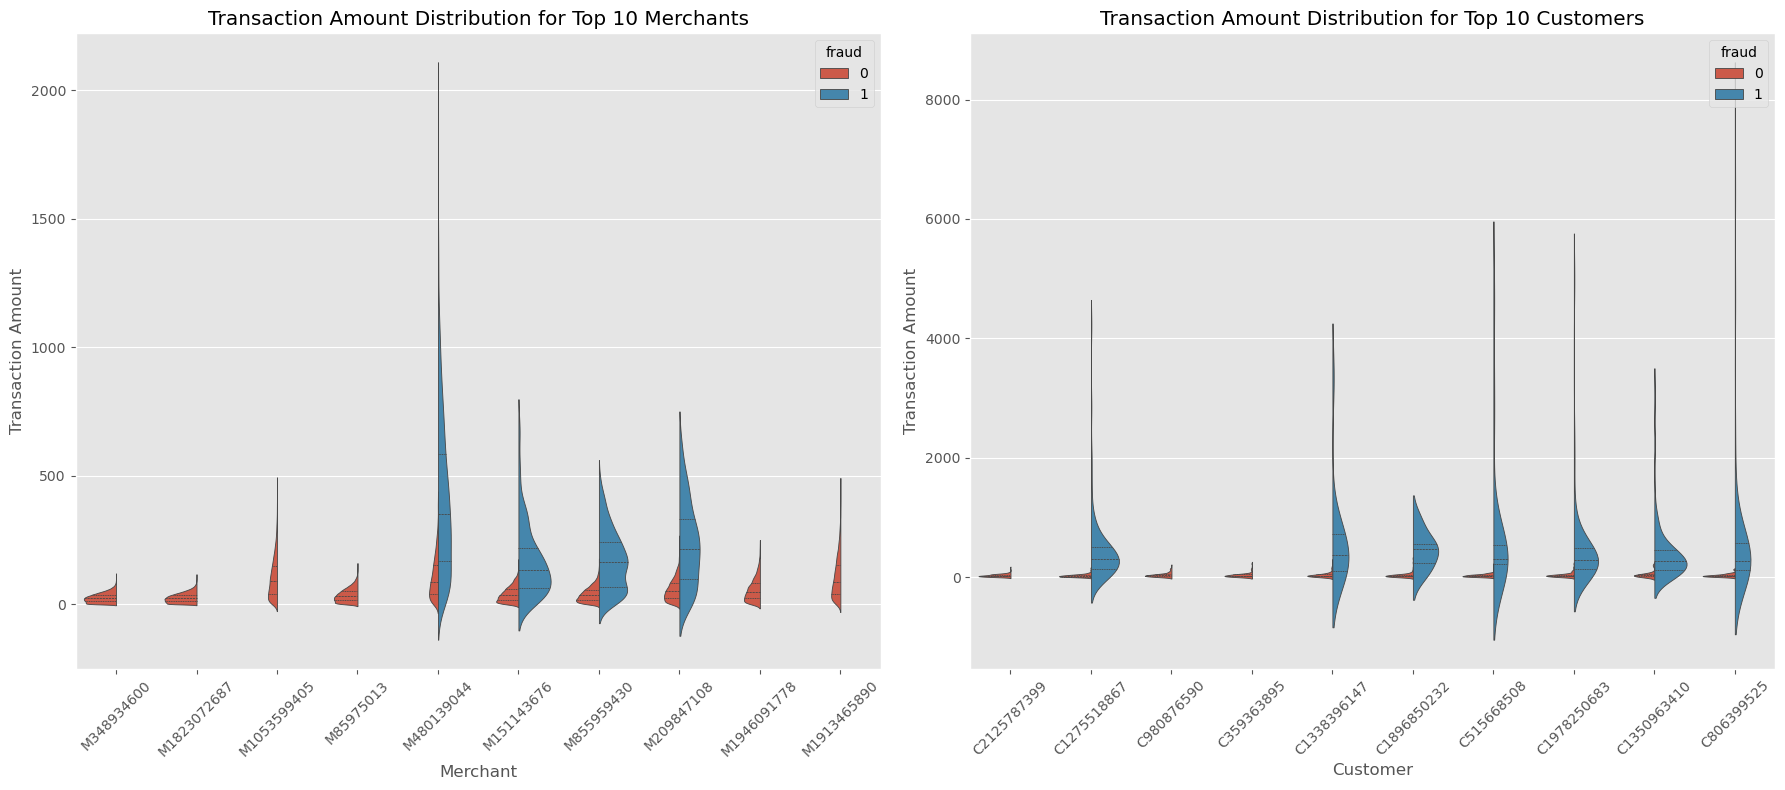

In [34]:
# Assuming df is your main dataframe and it contains columns 'merchant', 'amount', 'fraud', and 'customer'
# Identify top 10 merchants and customers by volume
top_merchants = df['merchant'].value_counts().nlargest(10).index
top_customers = df['customer'].value_counts().nlargest(10).index

# Create filtered dataframes
df_top_merchants = df[df['merchant'].isin(top_merchants)]
df_top_customers = df[df['customer'].isin(top_customers)]

# Setting up a figure for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Violin plot for top 10 merchants
sns.violinplot(x='merchant', y='amount', hue='fraud', data=df_top_merchants, split=True, inner='quartile', ax=axes[0])
axes[0].set_title('Transaction Amount Distribution for Top 10 Merchants')
axes[0].set_xlabel('Merchant')
axes[0].set_ylabel('Transaction Amount')
axes[0].tick_params(axis='x', rotation=45)  # Rotate x labels for better readability

# Violin plot for top 10 customers
sns.violinplot(x='customer', y='amount', hue='fraud', data=df_top_customers, split=True, inner='quartile', ax=axes[1])
axes[1].set_title('Transaction Amount Distribution for Top 10 Customers')
axes[1].set_xlabel('Customer')
axes[1].set_ylabel('Transaction Amount')
axes[1].tick_params(axis='x', rotation=45)  # Rotate x labels for better readability

plt.tight_layout()
plt.show()



### Behaviors over Time

To explore transaction behavior over time, we'll focus on the step variable. Analyzing this will help us understand trends, patterns, and anomalies over the specified time frame.

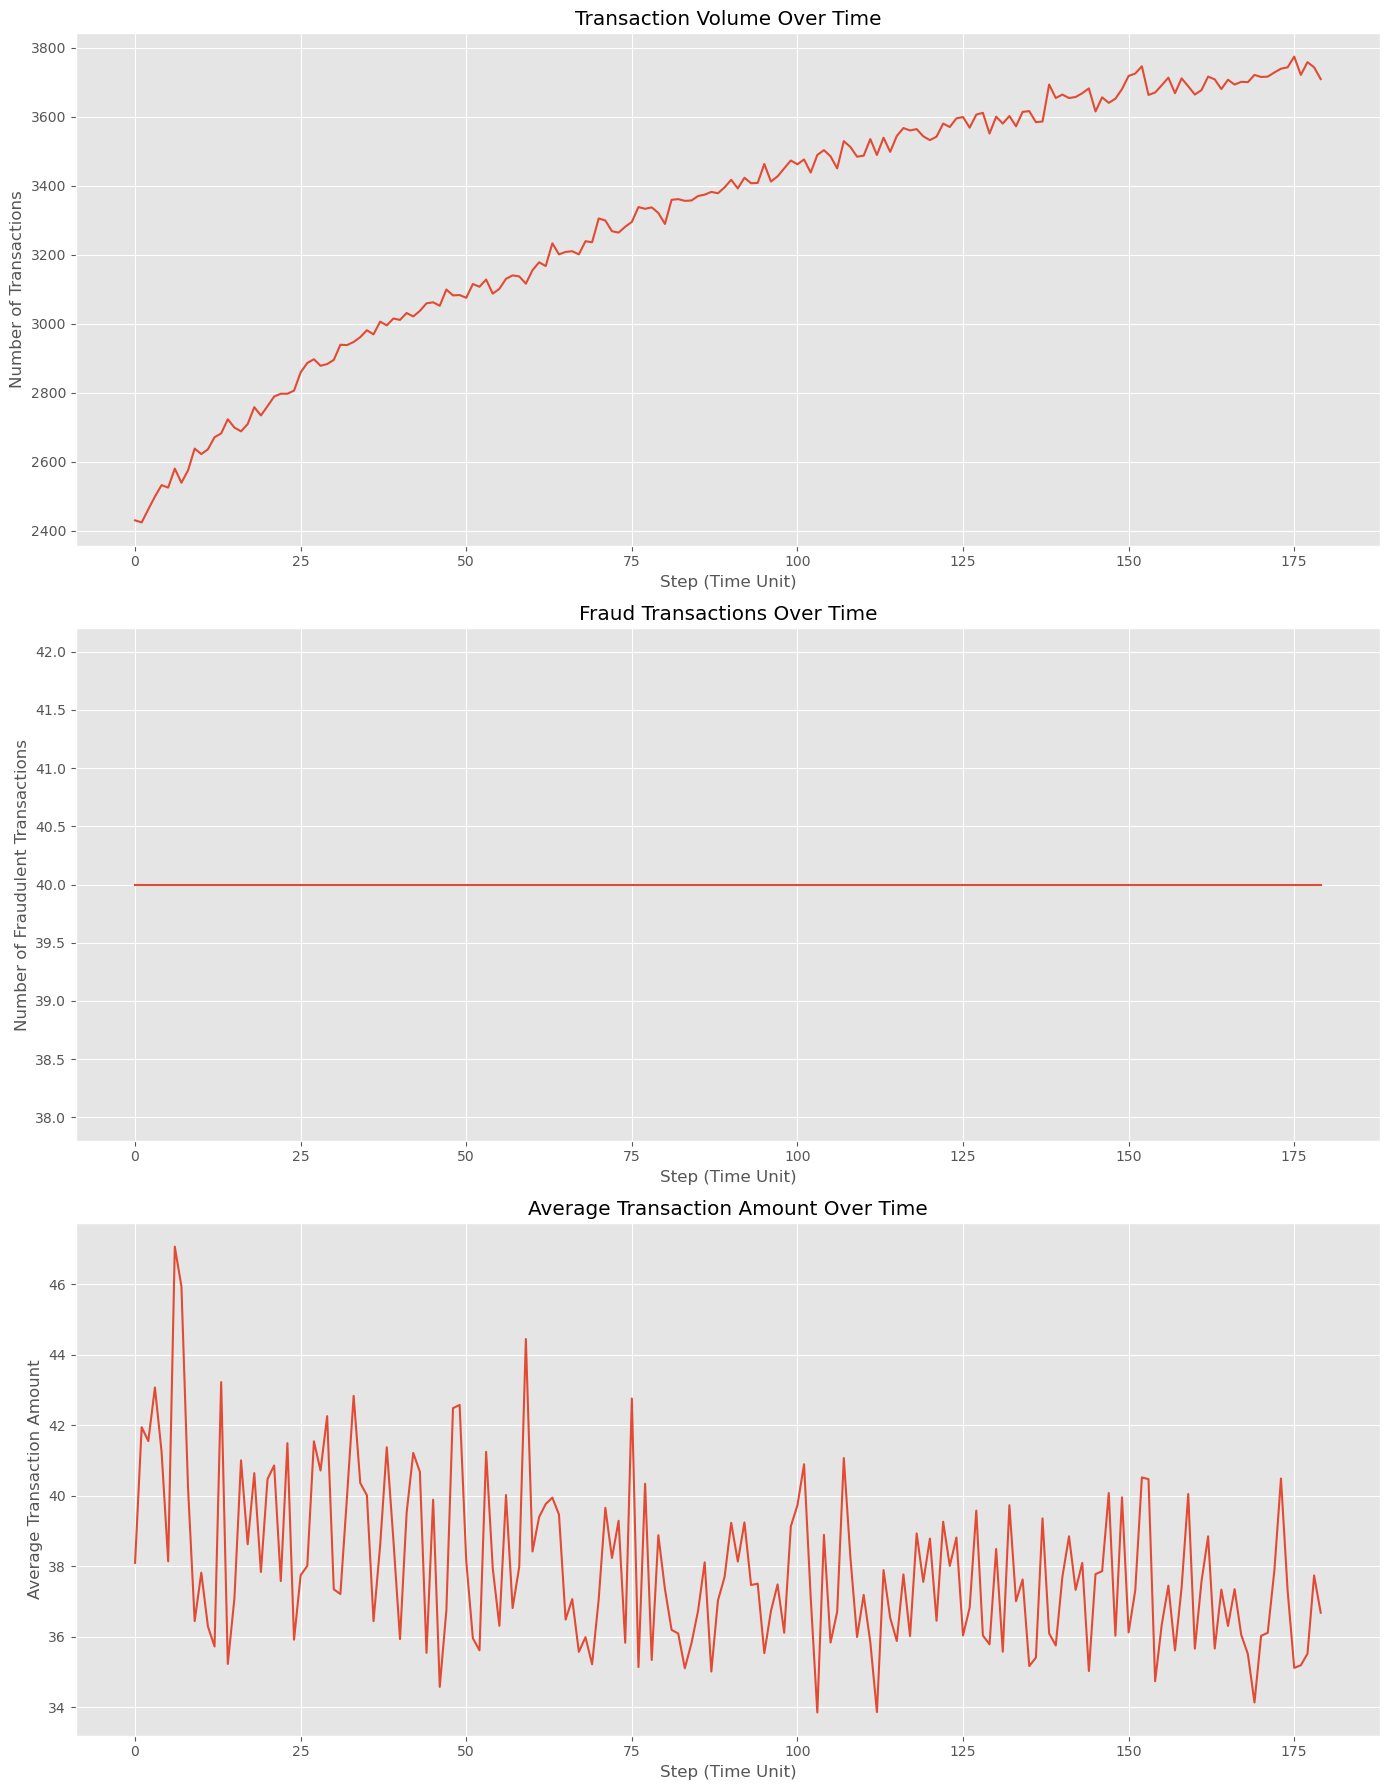

In [37]:
import numpy as np

# Group data by 'step' to summarize the information
time_grouped = df.groupby('step').agg({
    'amount': ['count', 'mean'],  # Count for volume and mean for average amount
    'fraud': ['sum']  # Sum of fraud occurrences
})

# Rename columns for easier understanding
time_grouped.columns = ['Transaction_Count', 'Average_Amount', 'Fraud_Count']
time_grouped.reset_index(inplace=True)

# Plotting the behavior over time
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Transaction Volume Over Time
sns.lineplot(x='step', y='Transaction_Count', data=time_grouped, ax=axes[0])
axes[0].set_title('Transaction Volume Over Time')
axes[0].set_xlabel('Step (Time Unit)')
axes[0].set_ylabel('Number of Transactions')

# Fraud Transactions Over Time
sns.lineplot(x='step', y='Fraud_Count', data=time_grouped, ax=axes[1])
axes[1].set_title('Fraud Transactions Over Time')
axes[1].set_xlabel('Step (Time Unit)')
axes[1].set_ylabel('Number of Fraudulent Transactions')

# Average Transaction Amount Over Time
sns.lineplot(x='step', y='Average_Amount', data=time_grouped, ax=axes[2])
axes[2].set_title('Average Transaction Amount Over Time')
axes[2].set_xlabel('Step (Time Unit)')
axes[2].set_ylabel('Average Transaction Amount')

plt.tight_layout()
plt.show()


Here are the plots depicting transaction behaviors over time based on the step variable:

- Transaction Volume Over Time: The first plot shows the number of transactions over each time unit (step). This can help us see overall activity patterns, including any periodic trends or anomalies in transaction volume.
- Fraud Transactions Over Time: The second plot focuses on the number of fraudulent transactions over time. It provides insights into whether there are specific periods with higher incidences of fraud, which might correlate with certain events or changes in transaction patterns.
- Average Transaction Amount Over Time: The third plot tracks the average transaction amount per time step. Fluctuations in this metric could indicate changes in purchasing behavior or potential shifts in fraudulent activity, especially if there are significant deviations from the norm.


# Model Preparation

In [40]:
'''

import shutil

# Directory where the tuner data is stored
#tuner_directory = 'C:/Users/trobb/GitHub/Projects/timothyrobbinscpa/fraud_analysis/src/my_dir/keras_tune_nn'
tuner_directory = 'C:/Users/trobb/GitHub/Projects/timothyrobbinscpa/fraud_analysis/src/hyperparam_tuning/neural_network_tuning'

# Remove the directory to reset the tuner
shutil.rmtree(tuner_directory, ignore_errors=True)

'''

"\n\nimport shutil\n\n# Directory where the tuner data is stored\n#tuner_directory = 'C:/Users/trobb/GitHub/Projects/timothyrobbinscpa/fraud_analysis/src/my_dir/keras_tune_nn'\ntuner_directory = 'C:/Users/trobb/GitHub/Projects/timothyrobbinscpa/fraud_analysis/src/hyperparam_tuning/neural_network_tuning'\n\n# Remove the directory to reset the tuner\nshutil.rmtree(tuner_directory, ignore_errors=True)\n\n"

In [41]:
class F1Score(tf.keras.metrics.Metric):
    """
    Custom implementation of the F1 Score as a Keras metric. The F1 Score is the harmonic mean of precision and recall,
    providing a balance between the two metrics. It is particularly useful when dealing with imbalanced datasets.
    
    Attributes:
        true_positives (tf.Variable): Tracks the number of true positives encountered over all batches.
        false_positives (tf.Variable): Tracks the number of false positives encountered over all batches.
        false_negatives (tf.Variable): Tracks the number of false negatives encountered over all batches.
    """

    def __init__(self, name='f1_score', **kwargs):
        """
        Initializes the F1Score metric instance.
        
        Args:
            name (str, optional): Name of the metric instance, defaults to 'f1_score'.
            **kwargs: Arbitrary keyword arguments, passed to the parent class.
        """
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Updates the state of the metric, accumulating the true positives, false positives, and false negatives 
        predictions based on the input labels and predictions.
        
        Args:
            y_true (tf.Tensor): The ground truth labels.
            y_pred (tf.Tensor): The predicted labels.
            sample_weight (tf.Tensor, optional): Optional weighting of each example, defaults to None.
        """
        y_pred = tf.round(y_pred)  # Convert probabilities to binary values (0 or 1)
        y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32 to match y_pred data type
        tp = tf.reduce_sum(y_true * y_pred)  # Calculate true positives
        fp = tf.reduce_sum(y_pred) - tp  # Calculate false positives
        fn = tf.reduce_sum(y_true) - tp  # Calculate false negatives

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        """
        Computes and returns the F1 Score using the current state of the metric.
        
        Returns:
            tf.Tensor: The computed F1 Score.
        """
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        """
        Resets all of the metric state variables to zero.
        This function is called at the start of each epoch.
        """
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)



In [42]:
# Separating the target variable 'fraud' from the feature set.
y = df['fraud']  # Target variable for prediction.
X = df.drop('fraud', axis=1)  # Feature set excluding the target.

# Identifying types of columns for preprocessing:
# - Categorical columns are identified by their data type ('object' or 'category').
# - Numerical columns are identified by data types 'int64' or 'float64', excluding the 'fraud' column.
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns.tolist() if col != 'fraud']


In [43]:
# Configure preprocessing for the neural network. This includes:
# - Standardizing numerical columns to have zero mean and unit variance.
# - One-hot encoding categorical columns to convert them into a format suitable for neural network training.
# Unspecified columns are dropped to ensure the model only trains on relevant features.
nn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Normalize numerical data.
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)  # Encode categorical data.
    ],
    remainder='drop'  # Drop other columns not specified explicitly.
)

# Apply the preprocessing transformations to the data, preparing it for the neural network.
X_nn_processed = nn_preprocessor.fit_transform(X)


In [44]:
# Preprocessing for Random Forest:
# Label encoding is applied to categorical columns to transform them into numerical values that the model can interpret.
X_rf = X.copy()  # Create a copy of the original feature set to modify for the Random Forest model.
for col in categorical_cols:
    le = LabelEncoder()
    X_rf[col] = le.fit_transform(X_rf[col])  # Encode each categorical column with label encoding.

# Apply standard scaling to numerical features to normalize their values, which helps in stabilizing the model training.
scaler = StandardScaler()
X_rf[numerical_cols] = scaler.fit_transform(X_rf[numerical_cols])  # Scale each numerical column.



In [45]:
# Split the preprocessed data into training and testing sets for neural network and random forest models.
# Both splits use a test size of 20% and a random state for reproducibility.
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn_processed, y, test_size=0.2, random_state=42)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y, test_size=0.2, random_state=42)

# SMOTE (Synthetic Minority Over-sampling Technique) is applied to address class imbalance by generating synthetic samples.
smote = SMOTE(random_state=42)
X_train_nn_smote, y_train_nn_smote = smote.fit_resample(X_train_nn, y_train_nn)
X_train_rf_smote, y_train_rf_smote = smote.fit_resample(X_train_rf, y_train_rf)



# Modeling

## Neural Network Model

In [49]:
class MyHyperModel(HyperModel):
    """
    A custom hypermodel class using Keras Tuner for optimizing a neural network model for binary classification.
    
    Attributes:
        input_shape (int): The shape of the input data that the model will accept.
    """

    def __init__(self, input_shape):
        """
        Initializes the hypermodel with the required input shape for the neural network.
        
        Args:
            input_shape (int): The number of features in the input dataset.
        """
        self.input_shape = input_shape

    def build(self, hp):
        """
        Builds and compiles a neural network model with hyperparameters that can be tuned.
        
        Args:
            hp (HyperParameters): A set of hyperparameters provided by Keras Tuner to optimize the model.
        
        Returns:
            model (tf.keras.Model): The compiled neural network model.
        """
        model = Sequential([
            Dense(units=hp.Int('units', min_value=128, max_value=512, step=32), activation='relu', input_shape=(self.input_shape,)),
            Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)),
            Dense(units=hp.Int('units_2', min_value=64, max_value=256, step=32), activation='relu'),
            Dropout(hp.Float('dropout_rate_2', min_value=0.1, max_value=0.5, step=0.1)),
            Dense(1, activation='sigmoid')
        ])
        model.compile(
            optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='binary_crossentropy',
            metrics=[F1Score(), Precision(name='precision'), Recall(name='recall')]
        )
        return model

# Instantiate the hypermodel for the neural network.
hypermodel = MyHyperModel(input_shape=X_train_nn_smote.shape[1])


In [106]:
# NN with Focus on Recall

import numpy as np
import tensorflow as tf
from keras_tuner import RandomSearch, Objective
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)  # Set numpy random seed
tf.random.set_seed(42)  # Set TensorFlow random seed

# Setup the Keras Tuner for hyperparameter optimization using the RandomSearch algorithm.
# The goal is to maximize the validation recall, limiting the search to a single trial for quick testing.
tuner = RandomSearch(
    hypermodel,
    objective=Objective('val_recall', direction='max'),  # Maximize recall
    max_trials=3,  # Run a single set of hyperparameter values
    executions_per_trial=1,  # Execute the model once per trial
    directory='hyperparam_tuning',
    project_name='neural_network_tuning_recall'
)

# Configure early stopping to prevent overfitting by monitoring the validation recall.
early_stopper = EarlyStopping(
    monitor='val_recall',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restores model weights from the epoch with the best value of the monitored quantity
    mode='max'  # The monitoring metric is expected to be maximized
)

# Perform the hyperparameter search over the training data with a validation split.
tuner.search(
    X_train_nn_smote, y_train_nn_smote,
    epochs=3,  # Limited number of epochs for quick iteration
    validation_split=0.2,  # 20% of the training data is used as validation data
    callbacks=[early_stopper]
)

# Retrieve the best model from the tuning session.
best_model = tuner.get_best_models(num_models=1)[0]


Trial 3 Complete [00h 15m 14s]
val_recall: 0.9998670220375061

Best val_recall So Far: 0.9998670220375061
Total elapsed time: 00h 30m 07s



In [107]:
# Fit the best model on the training data with validation using the test set.
history = best_model.fit(
    X_train_nn_smote, y_train_nn_smote,
    epochs=5,  # Number of epochs to train the model
    validation_data=(X_test_nn, y_test_nn),
    callbacks=[early_stopper]
)

# Evaluate the neural network model on the test data.
nn_predictions = (best_model.predict(X_test_nn) > 0.5).astype(int)  # Binary classification threshold
nn_prob_predictions = best_model.predict(X_test_nn).ravel()  # Probability predictions

# Print classification metrics and ROC-AUC score for model evaluation.
print("Neural Network Classification Report:\n", classification_report(y_test_nn, nn_predictions))
print("Neural Network ROC-AUC Score:", roc_auc_score(y_test_nn, nn_prob_predictions))


Epoch 1/5
29371/29371 [==============================] - 336s 11ms/step - loss: 0.0045 - f1_score: 0.9991 - precision: 0.9985 - recall: 0.9998 - val_loss: 0.0720 - val_f1_score: 0.8104 - val_precision: 0.8716 - val_recall: 0.7572
Epoch 2/5
29371/29371 [==============================] - 334s 11ms/step - loss: 0.0040 - f1_score: 0.9993 - precision: 0.9987 - recall: 0.9998 - val_loss: 0.1015 - val_f1_score: 0.8058 - val_precision: 0.8731 - val_recall: 0.7481
Epoch 3/5
29371/29371 [==============================] - 329s 11ms/step - loss: 0.0036 - f1_score: 0.9994 - precision: 0.9989 - recall: 0.9999 - val_loss: 0.1450 - val_f1_score: 0.7832 - val_precision: 0.8810 - val_recall: 0.7050
Epoch 4/5
29371/29371 [==============================] - 331s 11ms/step - loss: 0.0033 - f1_score: 0.9994 - precision: 0.9990 - recall: 0.9999 - val_loss: 0.1803 - val_f1_score: 0.7806 - val_precision: 0.8913 - val_recall: 0.6944
Epoch 5/5
3717/3717 [==============================] - 6s 2ms/step
Neural Networ

In [ ]:
# NEEDED FOR NN FEATURE IMPORTANCES

# Get feature names for neural network model

# Assuming nn_preprocessor is already defined and fitted as shown
# You must have X which includes all the columns used in X_nn_processed

# Function to get feature names from ColumnTransformer
def get_feature_names(column_transformer):
    # Collect the output column names from each transformer
    output_features = []

    for name, transformer, original_features in column_transformer.transformers_:
        if isinstance(transformer, OneHotEncoder):
            # Generate new feature names for one-hot encoded features
            for feature, cats in zip(original_features, transformer.categories_):
                output_features.extend([f"{feature}_{cat}" for cat in cats])
        elif hasattr(transformer, 'get_feature_names_out'):
            # If the transformer has a get_feature_names_out method, use it
            output_features.extend(transformer.get_feature_names_out(original_features))
        else:
            # Otherwise, simply add the feature names directly
            output_features.extend(original_features)

    return output_features

# Now you can call this function to get the feature names
nn_feature_names = get_feature_names(nn_preprocessor)

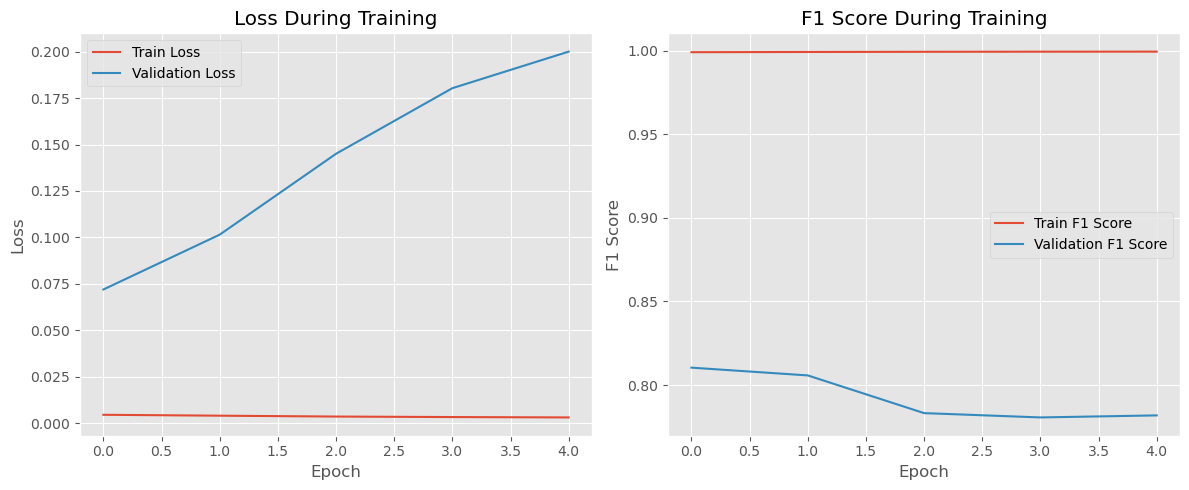

In [108]:
import matplotlib.pyplot as plt

# Adjust the figure size to better accommodate two plots side by side
plt.figure(figsize=(12, 5))  # Wider figure to prevent squeezing of plots

# Plot for training and validation loss
plt.subplot(1, 2, 1)  # One row, two columns, first plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot for F1 Score during training
plt.subplot(1, 2, 2)  # One row, two columns, second plot
plt.plot(history.history['f1_score'], label='Train F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.title('F1 Score During Training')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


## Random Forest Model

In [60]:
from sklearn.metrics import f1_score, make_scorer

# Create a custom scorer object that measures the F1 score for RF Model:
# The `make_scorer` function converts the `f1_score` metric into a scorer that can be used with scikit-learn's model evaluation and parameter tuning tools.
# The F1 score is a harmonic mean of precision and recall and is particularly useful for evaluating models on imbalanced datasets.
f1_scorer = make_scorer(f1_score)


In [61]:
# Random Forest with focus on recall

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import randint

# Initialize Random Forest classifier.
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid that RandomizedSearchCV will explore during tuning.
param_grid = {
    'n_estimators': randint(100, 300),
    'max_features': ['sqrt', 'log2'],
    'max_depth': randint(10, 40),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Setup RandomizedSearchCV with the defined grid and a focus on maximizing recall.
rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring='recall',  # Change this to 'recall'
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV to the training data to find the best parameters.
rf_random_search.fit(X_train_rf_smote, y_train_rf_smote)

# Retrieve the best estimator from the search.
best_rf = rf_random_search.best_estimator_

# Make predictions using the best Random Forest model found.
rf_predictions = best_rf.predict(X_test_rf)
rf_prob_predictions = best_rf.predict_proba(X_test_rf)[:, 1]

# Output the classification report and ROC-AUC score for the Random Forest model.
print("Random Forest Classification Report:\n", classification_report(y_test_rf, rf_predictions))
print("Random Forest ROC-AUC Score:", roc_auc_score(y_test_rf, rf_prob_predictions))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    117512
           1       0.63      0.89      0.74      1417

    accuracy                           0.99    118929
   macro avg       0.82      0.94      0.87    118929
weighted avg       0.99      0.99      0.99    118929

Random Forest ROC-AUC Score: 0.9952787205852052


In [62]:
# After fitting the Random Forest model:
rf_feature_importances = best_rf.feature_importances_

rf_feature_names = best_rf.feature_names_in_



In [63]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# Define the performance metrics for comparison.
metrics = ['Precision', 'Recall', 'F1 Score', 'ROC AUC']

# Compute scores for the Neural Network model.
nn_scores = [
    precision_recall_fscore_support(y_test_nn, nn_predictions, average='binary')[0],  # Precision
    precision_recall_fscore_support(y_test_nn, nn_predictions, average='binary')[1],  # Recall
    precision_recall_fscore_support(y_test_nn, nn_predictions, average='binary')[2],  # F1 Score
    roc_auc_score(y_test_nn, nn_prob_predictions)  # ROC AUC
]

# Compute scores for the Random Forest model.
rf_scores = [
    precision_recall_fscore_support(y_test_rf, rf_predictions, average='binary')[0],  # Precision
    precision_recall_fscore_support(y_test_rf, rf_predictions, average='binary')[1],  # Recall
    precision_recall_fscore_support(y_test_rf, rf_predictions, average='binary')[2],  # F1 Score
    roc_auc_score(y_test_rf, rf_prob_predictions)  # ROC AUC
]

# Setup for plotting the comparison.
x = np.arange(len(metrics))  # Label locations for metrics
width = 0.35  # Width of the bars

# Create a figure and a set of subplots.
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, nn_scores, width, label='Neural Network')  # Bars for Neural Network
rects2 = ax.bar(x + width/2, rf_scores, width, label='Random Forest')   # Bars for Random Forest

# Add some text for labels, title, and custom x-axis tick labels.
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add text annotations above each bar for clarity.
def add_value_labels(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(ax, rects1)
add_value_labels(ax, rects2)

# Improve the layout to make room for the tick labels.
fig.tight_layout()

# Display the plot.
plt.show()


NameError: name 'nn_predictions' is not defined

Accuracy:

Both models perform similarly, with very high accuracy scores: 1.0 for the Random Forest and 0.99 for the Neural Network.
Accuracy measures the proportion of true results (both true positives and true negatives) among the total number of cases examined.
Precision:

The Random Forest model has a recall of 0.77, whereas the Neural Network has a recall of 0.84.
Precision measures the proportion of true positive identifications, meaning it is the number of true positives divided by the number of true positives plus the number of false positives. A higher precision score indicates a lower false positive rate.
Recall:

The Random Forest model has a precision of 0.9, which is significantly higher than the Neural Network's precision of 0.48.
Recall (also known as sensitivity) measures the proportion of actual positives that were identified correctly. It is the number of true positives divided by the number of true positives plus the number of false negatives. A higher recall score indicates that the model is better at capturing the positive class.
F1 Score:

The Random Forest model has an F1 score of 0.8, which is higher than the Neural Network's F1 score of 0.62.
The F1 Score is the harmonic mean of Precision and Recall. An F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a model has a good balance between precision and recall.
Overall Interpretation:
The Random Forest model appears to have better recall and F1 scores, indicating it is better at correctly identifying the positive class and balancing precision and recall.
The Neural Network has a slightly better precision but a significantly lower recall, suggesting it is more conservative in predicting the positive class but misses a substantial number of positive cases.
In terms of accuracy, both models perform exceptionally well, but this metric alone can be misleading, especially if the class distribution is imbalanced. It's important to consider the context of the problem: if false positives and false negatives have different costs, precision and recall might be more important than accuracy.
When deciding between the two models, you would consider the specific requirements of your application. If minimizing false negatives is crucial (thus requiring a high recall), the Random Forest seems preferable. If you want to ensure that the positive predictions are correct (requiring high precision), then the Neural Network might be the better choice, albeit only slightly.

Lastly, the F1 score suggests that the Random Forest has a better overall balance of precision and recall, making it a good choice if you value both metrics equally.










### PR ROC Curve

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Assuming 'nn_prob_predictions' are the prediction probabilities for the positive class from the Neural Network model
# and 'rf_prob_predictions' are the prediction probabilities for the positive class from the Random Forest model.
# Also assuming 'y_test_nn' is the actual labels for the test dataset used for both models.

# Calculate the precision-recall curve and AUC for the Neural Network
nn_precision, nn_recall, _ = precision_recall_curve(y_test_nn, nn_prob_predictions)
nn_auc = auc(nn_recall, nn_precision)

# Calculate the precision-recall curve and AUC for the Random Forest
rf_precision, rf_recall, _ = precision_recall_curve(y_test_rf, rf_prob_predictions)
rf_auc = auc(rf_recall, rf_precision)

# Plotting the Precision-Recall curves
plt.figure(figsize=(8, 6))
plt.plot(nn_recall, nn_precision, label=f'Neural Network PR (AUC = {nn_auc:.4f})', linestyle='-', linewidth=2)
plt.plot(rf_recall, rf_precision, label=f'Random Forest PR (AUC = {rf_auc:.4f})', linestyle='--', linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='best')
plt.grid(True)
plt.show()


a Precision-Recall (PR) Curve, which is used to evaluate the performance of a classification model at different probability thresholds. The PR curve plots the Precision (y-axis) against the Recall (x-axis).

Here’s an interpretation of the plot:

Precision-Recall Trade-off: The curves show the trade-off between precision and recall for the Random Forest and Neural Network models. As the recall increases, precision tends to decrease, which is typical behavior for classifiers.

Random Forest Model (Red Curve):

The Random Forest model has a Precision-Recall Area Under the Curve (PR AUC) of 0.8960.
It starts with high precision but experiences a gradual decline as recall increases.
The relatively high PR AUC value suggests that the Random Forest model has a good balance between precision and recall overall.
Neural Network Model (Blue Curve):

The Neural Network model has a PR AUC of 0.8486, which is slightly lower than the Random Forest model.
This curve also demonstrates the trade-off, with precision decreasing as recall increases.
While the Neural Network performs well, it is slightly outperformed by the Random Forest model in terms of the area under the PR curve.
Comparison:

Both models perform relatively well, with PR AUC scores close to 1, indicating strong performance.
However, the Random Forest model has a higher PR AUC, suggesting it is better at distinguishing between the positive and negative classes across different thresholds.
The curves are close to each other, which means the performance of both models is somewhat similar, but the Random Forest has a slight edge.
PR AUC Scores:

The PR AUC scores are included in the legend. Higher PR AUC scores are generally better, indicating a model that maintains high precision across different levels of recall.
These scores provide a single measure of performance across all classification thresholds, unlike the curves that show performance at each threshold.
In conclusion, based on this PR curve, the Random Forest model is slightly superior to the Neural Network for the task at hand, likely due to its ability to maintain higher precision at similar levels of recall. When choosing between models, if precision is more critical for the application (i.e., minimizing false positives), the Random Forest might be the preferred model. If you need to prioritize recall (i.e., minimizing false negatives), the performance difference between the models is less pronounced.





### Cumulative Gain Curve

In [ ]:
# pip install scikit-plot

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

# Assuming you have the actual labels 'y_test_nn' and 'y_test_rf'
# and the prediction probabilities 'nn_prob_predictions' and 'rf_prob_predictions'

# For scikit-plot, we need to stack the probabilities of the negative and positive classes
# If you only have the probabilities for the positive class, you can construct the required format like this:
nn_prob_predictions_stacked = np.vstack((1-nn_prob_predictions, nn_prob_predictions)).T
rf_prob_predictions_stacked = np.vstack((1-rf_prob_predictions, rf_prob_predictions)).T

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Cumulative Gain Curve for Neural Network on the first subplot
skplt.metrics.plot_cumulative_gain(y_test_nn, nn_prob_predictions_stacked, ax=ax1)
ax1.set_title('Cumulative Gains Curve - Neural Network')

# Plot Cumulative Gain Curve for Random Forest on the second subplot
skplt.metrics.plot_cumulative_gain(y_test_rf, rf_prob_predictions_stacked, ax=ax2)
ax2.set_title('Cumulative Gains Curve - Random Forest')

# Show plot with tight layout
plt.tight_layout()
plt.show()



Here’s what we can interpret from these graphs:

- Curve Position Relative to Baseline: Both graphs have a blue line representing the gain for Class 1 (positive class) and a dashed line representing the baseline. The baseline represents a random selection model. The further away the blue line is from the baseline, the better the model is at identifying the positive class.
- Initial Steepness: The steepness of the curves at the start is indicative of the model's effectiveness. Both curves show a rapid initial increase, which suggests that targeting a small percentage of the total sample based on the model's predictions can capture a significant portion of the positive class. This is an indicator of good model performance.
- Comparative Performance: Visually, the gains curves for the Neural Network and Random Forest models appear quite similar. Both models quickly rise and then plateau, which indicates that they both effectively prioritize the positive class instances over the negative class.
- Plateau Level: After the initial steep rise, the curves plateau, meaning additional gains in capturing more of the positive class become smaller as more of the sample is targeted. In other words, after a certain point, you need to target many more samples to find the remaining few positives.
- Class 0 Representation: The orange lines representing Class 0 (negative class) are close to the baseline, which is as expected. It means that as you target more of the sample, you gain nearly equal proportions of negative and positive classes — the model is not effectively distinguishing the negative class when moving towards targeting the entire sample, which is typical behavior.


### AUC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Replace these with the actual names of your variables for the true labels
# and predicted probabilities from the Neural Network and Random Forest models.
# y_test_nn = # the true labels for the test set used with the Neural Network
# y_test_rf = # the true labels for the test set used with the Random Forest
# nn_prob_predictions = # the predicted probabilities for the positive class from the Neural Network
# rf_prob_predictions = # the predicted probabilities for the positive class from the Random Forest

# Compute ROC curve and ROC area for the Neural Network
fpr_nn, tpr_nn, _ = roc_curve(y_test_nn, nn_prob_predictions[:, 1])
roc_auc_nn = auc(fpr_nn, tpr_nn)

# Compute ROC curve and ROC area for the Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test_rf, rf_prob_predictions[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plotting the ROC curves
plt.figure(figsize=(10, 8))
lw = 2  # Line width
plt.plot(fpr_nn, tpr_nn, color='blue', lw=lw, label='Neural Network ROC curve (area = %0.2f)' % roc_auc_nn)
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=lw, label='Random Forest ROC curve (area = %0.2f)' % roc_auc_rf)

# Plot ROC curve for a model with no skill
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='No Skill')

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### Feature Importances (Random Forest)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'rf_feature_importances' and 'rf_feature_names' are already defined

# Create a sorted list of feature importances and corresponding names from largest to smallest
sorted_indices = np.argsort(rf_feature_importances)[::-1]  # Get the indices to sort in descending order
sorted_importances = np.array(rf_feature_importances)[sorted_indices]
sorted_names = np.array(rf_feature_names)[sorted_indices]

x = np.arange(len(sorted_importances))  # positions for the Random Forest bars
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(15, 6))
rf_bars = ax.bar(x, sorted_importances, width, label='Random Forest', color='skyblue')

ax.set_ylabel('Feature Importance Score')
ax.set_title('Random Forest Feature Importances')
ax.set_xticks(x)
ax.set_xticklabels(sorted_names, rotation=45)
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rf_bars)

fig.tight_layout()
plt.show()


Random Forest Model (Red Bars):

The feature amount has the highest importance, indicating it is the most influential feature for the Random Forest model when making predictions.
The category feature also appears to be quite significant, followed by merchant, suggesting these features play a strong role in the model's decisions.
Customer has a moderate level of importance.
Features such as step, age, and gender have very low importance in the Random Forest model, implying they have minimal impact on the model's predictions.
Neural Network Model (Blue Bars):

Similar to the Random Forest model, the amount feature is highly important in the Neural Network model but to a slightly lesser degree.
The category and merchant features have a noticeable level of importance, but merchant is less important compared to the Random Forest model.
The customer feature is more important in the Neural Network model than in the Random Forest model.
Similar to the Random Forest, step, age, and gender have lower importance, with gender having the least importance among all features.
Comparative Insights:
Both models agree on the high importance of the amount feature, which likely has a strong correlation with the target variable.
The category feature is also considered important by both models, which might suggest that certain categories have a higher likelihood of being associated with the target variable.
There is a notable difference in how the models weigh the importance of customer and merchant. The Neural Network gives more importance to customer than the Random Forest model, which might be due to differences in how these models capture and use information from the data.
The step, age, and gender features are consistently given low importance by both models, indicating these features may not be very useful in predicting the outcome.
Differences in feature importance between the two models can arise due to the intrinsic differences in how Random Forests and Neural Networks learn from the data. Random Forests use decision trees that make splits based on reducing entropy or Gini impurity, while Neural Networks learn a set of weights through backpropagation, which can capture more complex and non-linear relationships.

In [ ]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total runtime of the program is {total_time/(60 * 60)} hours")
